### SWE IVP

In [1]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Current verison of Python is", sys.version)

import os
import pathlib
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import dedalus.core as dec
from dedalus.tools import post 
import logging
logger = logging.getLogger(__name__)
plt.rcParams['text.usetex'] = True

from dedalus.core.operators import GeneralFunction
from dedalus.extras import flow_tools
import shutil
from mpi4py import MPI

Current verison of Python is 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:38:53) [Clang 18.1.8 ]


In [ ]:
### Simulation Parameters

Nx = 128 #64
Ny = 512 #128
Ly = 20*np.pi
Lx = 10
y0 = Ly/4

print(f"Spacing: {20*np.pi/Ny}")

Spacing: 0.1227184630308513


In [ ]:
h_g = None
u_g = None
v_g = None
eig_sel = None


### EVP PARAMETERS 
kx  = None
# target_omega = 0.7
h_gs = []
u_gs = []
v_gs = []
y = None


In [ ]:

def EVP_solve(k_x, target_omega, alph, f0):
    alpha = alph
    y    = d3.Coordinate('y')
    dist = d3.Distributor(y, dtype=np.complex128)
    Y    = d3.ComplexFourier(y, size=Ny, bounds=(-Ly/2, Ly/2))

    _dy   = lambda A: d3.Differentiate(A, y)
    _dx   = lambda A: (-1j*k_x)*A           
    _dt   = lambda A: ( 1j)*omega*A         
    # lift = lambda A: d3.Lift(A, Y.derivative_basis(1), -1)

    u = dist.Field(name='u', bases=Y)
    v = dist.Field(name='v', bases=Y)
    h = dist.Field(name='h', bases=Y)
    omega = dist.Field(name='omega')        

    yy = dist.local_grids(Y)[0]
    f  = dist.Field(name='f', bases=Y)
    # f['g'] = np.sin(2*np.pi*yy/Ly)
    f['g'] = f0*(np.tanh(alph*(yy-y0)) -np.tanh(alph*(yy+y0)) +1)

    problem = d3.EVP([u, v, h], eigenvalue=omega, namespace=locals())
    problem.add_equation("_dt(u) + _dx(h) - f*v = 0")
    problem.add_equation("_dt(v) + _dy(h) + f*u = 0")
    problem.add_equation("_dt(h) + _dx(u) + _dy(v) = 0")
    # problem.add_equation("v(y='left')  = 0")
    # problem.add_equation("v(y='right') = 0")

    solver = problem.build_solver()

    solver.solve_dense(solver.subproblems[0])

    order = np.argsort(solver.eigenvalues.real)
    eigs  = solver.eigenvalues[order]
    print("First few eigenvalues:", eigs[:50])

    # pick 
    tol = 1e-3
    # cand = np.where(np.abs(eigs.real - target_omega) < tol)[0]
    omega_idx = np.argmin(np.abs(eigs.real - target_omega))

    omega_idx_unsorted = np.argmin(np.abs(solver.eigenvalues.real - target_omega))
    eig_sel = eigs[omega_idx]
    cand_doublet = np.where((np.abs(eigs.real - target_omega) < tol) & (eigs.real !=eig_sel))[0]
    # omega_idx_unsorted_doublet = cand_doublet[0] if cand.size else np.argmin(np.abs(solver.eigenvalues.real - target_omega))
    # eig_doublet = eigs[omega_idx_unsorted_doublet]
    print(f"Alpha = {alph} Omega:", eig_sel.real, " Doublet: ", eigs[omega_idx-1].real)

    ### Find h for each doublet mode
    solver.set_state(omega_idx_unsorted)
    y1d = dist.local_grids(Y, scales=1)[0]
    h_g = h['g'].copy()
    u_g = u['g'].copy()
    v_g = v['g'].copy()
    
    # print(omega_idx_unsorted_doublet)
    # solver.set_state(omega_idx_unsorted_doublet)
    # h_g_doublet = h['g'].copy()

    # plot
    plt.figure(figsize=(9, 6))
    plt.plot(y1d, np.real(h_g), color = 'black', lw = 2)
    # plt.plot(y1d, np.real(h_g_doublet))

    ############### AXES, LABELS, SPINES 
    plt.tick_params('both', size = 8, width = 1.5, direction = 'in')
    plt.xlabel('$$y$$', fontsize = 25, color = 'dimgray')
    plt.ylabel('$$h$$', fontsize = 25, color = 'dimgray')


    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('dimgray')
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(f'$$\\alpha={alph}, k_x = {k_x},  \\omega = {eig_sel.real:.6f}, f_0 = {f0}$$',  fontsize = 25, color = 'dimgray')
    # axin.tick_params(axis='both', colors='dimgray') 
    ax.tick_params(axis='both', colors='dimgray') 


    # Flip Kelvin if amplitude is negative 
    # if(h_g[np.argmax(h_g**2)]<0): 
    #     h_g*=-1### flip if negative
    #     u_g*=-1### flip if negative
    #     # v_g*=-1### flip if negative

    # plt.savefig(f'/Users/Luitbald/CODE/Dedalus/ShallowWaterEquations/dedalus_figures/{alpha}_{Ny}res_yanai.png', dpi = 400)

    h_gs.append(np.real(h_g))
    u_gs.append(np.real(u_g))
    v_gs.append(np.real(v_g))

2025-10-16 09:01:21,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s
First few eigenvalues: [-25.64063532+4.24901851e-19j -25.54862226+1.88035762e-16j
 -25.54079492+9.45623934e-16j -25.44881339+7.96357131e-15j
 -25.44872988+7.79058941e-15j -25.34987373-2.76581924e-15j
 -25.34892185-3.03139641e-15j -25.25007125+2.65424345e-15j
 -25.25005206+2.63692638e-15j -25.15059146+2.73392392e-15j
 -25.15025099+2.79082967e-15j -25.05079341-6.94906876e-15j
 -25.05078573-1.27929777e-14j -24.95116249-5.70674946e-15j
 -24.95098924-5.74935745e-15j -24.85136836+8.96211806e-15j
 -24.85136441+9.09631899e-15j -24.75167668+3.39818597e-15j
 -24.75157191+3.41619845e-15j -24.6518863 +1.37210298e-14j
 -24.65188396+2.01565224e-14j -24.55216544+7.41732792e-16j
 -24.55209526+7.24133271e-16j -24.45237877+1.25909433e-14j
 -24.45237725+1.55847228e-14j -24.35264261-1.33090674e-15j
 -24.35259232-1.38934717e-15j -24.25285967+1.44697580e-14j
 -24.25285861+1.894

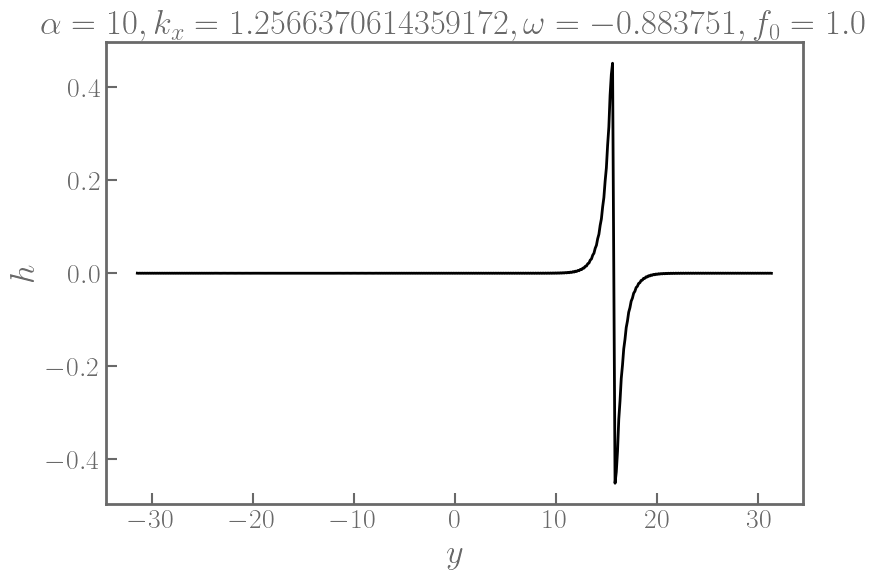

In [ ]:
f0s= [1.0, 1.0, 1.0, 1.0]
omtargets= [-0.7]
alphas = [10]
kxs = [2*(2*np.pi/Lx), -2*(2*np.pi/Lx)]
# omtargets = kxs ### for Kelvin modes only
for i in range(len(alphas)): 
    EVP_solve(kxs[i], omtargets[i], alphas[i], f0s[i])

### IMPORTANT: set kx: 
kx = kxs[0]
alpha = alphas[0]


In [ ]:
#### SET IVP PARAMETERS

# eigenmode_h =(h_gs[0] + h_gs[1])
# eigenmode_u =( u_gs[0] + h_gs[1])
# eigenmode_v =( v_gs[0] + h_gs[1])
eigenmode_h = h_gs[0] 
eigenmode_u =  u_gs[0]
eigenmode_v = v_gs[0] 



In [12]:
coords = d3.CartesianCoordinates('x','y')
dist = d3.Distributor(coords, dtype=np.float64)

x_basis = d3.RealFourier(coords['x'], Nx, bounds=[-Lx/2, Lx/2], dealias=1.0)
y_basis = d3.RealFourier(coords['y'], Ny, bounds=[-Ly/2, Ly/2], dealias = 1.0)
# lift_basis = y_basis.derivative_basis(1)

# tau_basis = y_basis.derivative_basis(1)
# #
u = dist.Field(name='u', bases=[x_basis, y_basis])
v = dist.Field(name='v', bases=[x_basis, y_basis])
h = dist.Field(name='h', bases=[x_basis, y_basis])
f = dist.Field(name='f', bases=[y_basis])

g_op = lambda A: A*f

# p1 = dist.Field(bases = tau_basis)
# p2 = dist.Field(bases = tau_basis)
# p1['c'][-1] = 1
# p2['c'][-1] = 1

# tau_1 = dist.Field(name = 'tau_1', bases = x_basis)
# tau_2 = dist.Field(name = 'tau_2', bases = x_basis)

dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])
# lift = lambda A: d3.Lift(A, lift_basis, -1)

x, y = dist.local_grids(x_basis, y_basis)
f['g'] = np.tanh(alpha*(y - y0)) - np.tanh(alpha*(y + y0)) + 1.0 #TANH CORIOLIS PARAMETER
# f['g'] =np.sin(2*np.pi*y/Ly) #sin coriolis parameter 

# Initial conditions
u['g'] = eigenmode_u.real*np.cos(kx*x)
v['g'] = eigenmode_v.real*np.cos(kx*x)
h['g'] = eigenmode_h.real*np.cos(kx*x)


# IVP without user taus
problem = d3.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + dx(h) - f*v = 0")
problem.add_equation("dt(v) + dy(h) + f*u  = 0")
problem.add_equation("dt(h) + dx(u) + dy(v) = 0")

# BCs in y (Chebyshev direction)
# problem.add_equation("v(y='left') = 0")
# problem.add_equation("v(y='right') = 0")

solver = problem.build_solver('RK222')  

2025-10-16 09:02:45,037 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 13s, Rate: 5.0e+00/s
2025-10-16 09:02:46,019 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 1s, Remaining: 10s, Rate: 5.9e+00/s
2025-10-16 09:02:47,176 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 2s, Remaining: 8s, Rate: 6.0e+00/s
2025-10-16 09:02:48,326 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 3s, Remaining: 7s, Rate: 6.0e+00/s
2025-10-16 09:02:49,495 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 5s, Remaining: 6s, Rate: 6.0e+00/s
2025-10-16 09:02:50,631 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 6s, Remaining: 5s, Rate: 6.0e+00/s
2025-10-16 09:02:51,756 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 7s, Remaining: 4s, Rate: 6.1e+00/s
2025-10-16 09:02:52,888 subsystems 0/1 INFO :: Building subproblem mat

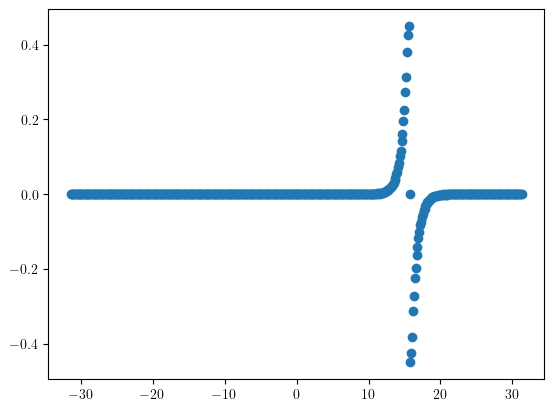

In [13]:
plt.scatter(y, h['g'][1])

In [ ]:
solver.stop_sim_time = 50
solver.stop_wall_time = np.inf
solver.stop_iteration = 1000

vel = d3.VectorField(dist,coordsys =coords, bases=(x_basis, y_basis), name='vel')


init_dt = 0.001
CFL = flow_tools.CFL(solver, initial_dt=init_dt, cadence=10, safety=0.3, max_change=1.5)
CFL.add_velocity(vel)

u_max= []
u_list = []
h_list = []
t_list = []

logger.info('Starting loop')
start_time = time.time()
dt = 0.005
while solver.proceed:
    solver.step(dt)

    vel['g'][0] = u['g'].real
    vel['g'][1] = v['g'].real

    dt = CFL.compute_timestep()
    t_list.append(solver.sim_time)
    u_list.append(np.copy(u['g']))
    h_list.append(np.copy(h['g']))
    
    
    if solver.iteration % 10 == 0:
        print('Completed iteration {}, time {}, dt {}'.format(solver.iteration, t_list[-1], dt))

end_time = time.time()


logger.info('Run time: %f' %(end_time-start_time))

logger.info('Iterations: %i' %solver.iteration)

2025-10-16 09:02:55,401 __main__ 0/1 INFO :: Starting loop
Completed iteration 10, time 0.014000000000000005, dt 0.001
Completed iteration 20, time 0.02850000000000002, dt 0.0015
Completed iteration 30, time 0.05025000000000004, dt 0.0022500000000000003
Completed iteration 40, time 0.08287500000000006, dt 0.0033750000000000004
Completed iteration 50, time 0.1278225290760783, dt 0.0046191698973420256
Completed iteration 60, time 0.17540345523143874, dt 0.004773528473113148
Completed iteration 70, time 0.22282083941547776, dt 0.004738206190102885
Completed iteration 80, time 0.26923271995308656, dt 0.004630408260833985
Completed iteration 90, time 0.3147482854772575, dt 0.004542795251481871
Completed iteration 100, time 0.3595335965656405, dt 0.00447139064854459
Completed iteration 110, time 0.40370023898783924, dt 0.004410583530406045
Completed iteration 120, time 0.44741470435302455, dt 0.004367097981642153
Completed iteration 130, time 0.49082596618502866, dt 0.00433824042781802
Compl

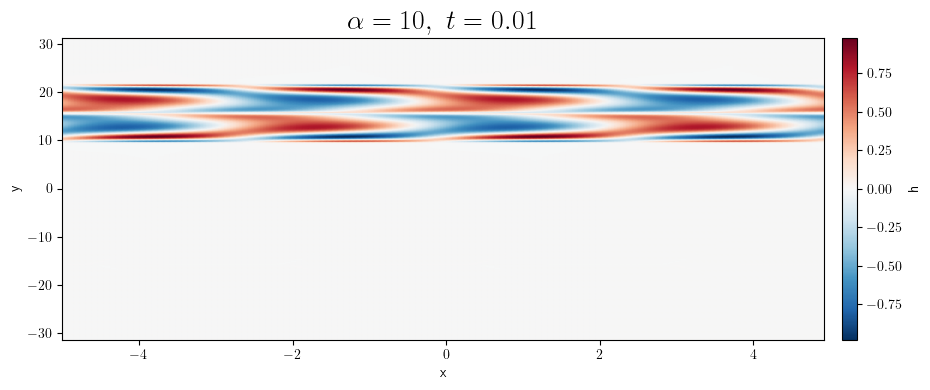

In [ ]:
xd, yd = dist.local_grids(x_basis, y_basis, scales=(1, 1))  
Xm, Ym = np.meshgrid(xd, yd, indexing='xy')  

import matplotlib.colors as mcolors

H = h_list[-1]
U = u_list[-1]    
fig, ax = plt.subplots(figsize=(10,4))
lim = np.nanmax(np.abs(H))
norm = mcolors.TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)
pc = ax.pcolormesh(Xm, Ym, H.T, shading='gouraud',norm = norm, cmap='RdBu_r')  
fig.colorbar(pc, ax=ax, pad=0.02).set_label('h')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title(rf'$\alpha = {alpha},\ t = {t_list[0]:6.2f}$', fontsize = 20)
plt.tight_layout(); plt.show()


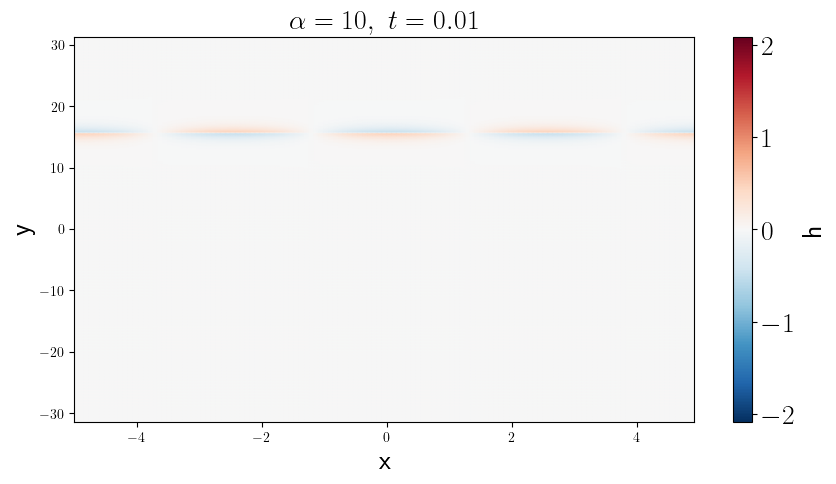

In [ ]:
from matplotlib import animation 

xm, ym = np.meshgrid(x,y)

fig, axis = plt.subplots(figsize=(10,5))

lim  = np.nanmax(np.abs(h_list))
norm = mcolors.TwoSlopeNorm(vmin=-lim, vcenter=0.0, vmax=lim)
p = axis.pcolormesh(xm, ym, np.array(h_list[0]).T,norm = norm, cmap='RdBu_r', shading='gouraud')
axis.set_title(rf'$\alpha = {alpha},\ t = {t_list[0]:6.2f}$', fontsize = 20)
axis.set_xlabel('x',fontsize=20)
axis.set_ylabel('y',fontsize=20)
cbar = fig.colorbar(p,ax=axis)
cbar.set_label('h', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
u_all = np.array(u_list)
h_all = np.array(h_list)
plt.show()
def init():
    p.set_array(np.ravel(np.array(h_list[0]).T))
    return p

def animate(i): 

    p.set_array(np.ravel(np.array(h_list[(i+1)*10]).T))
    axis.set_title(fr'$\alpha = {alpha},\; t = {t_list[(i+1)*10]:6.2f}$')

    return p


ani = animation.FuncAnimation(fig, animate, frames=int(len(t_list)/10-1))
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='L'), bitrate=2000)


In [18]:
import os
from datetime import datetime

ani.save(f'/Users/luitbald/CODE/Dedalus/ShallowWaterEquations/movies/{datetime.now().strftime("%y-%m-%d %H:%M")}_tanh_yanai_h_kx{kx}_alpha{alpha}.mp4', writer=writer)
plt.show()

2025-10-16 10:06:44,759 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-10-16 10:06:44,764 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x500 -pix_fmt rgba -framerate 10 -i pipe: -vcodec h264 -pix_fmt yuv420p -b 2000k -metadata artist=L -y '/Users/luitbald/CODE/Dedalus/ShallowWaterEquations/movies/25-10-16 10:06_tanh_yanai_h_kx1.2566370614359172_alpha10.mp4'


In [ ]:
#Save Data
np.savez(f'/Users/luitbald/CODE/dedalus/ShallowWaterEquations/data/alpha{alpha}kx{kx:.3f}data.npz', h_list = h_list, u_list = u_list)